# Data Analytics Project - Models

# Pair 3 - TWL ARIMA Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from pmdarima.arima import auto_arima
from sklearn import metrics

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 3 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair3/Pair3_orders.csv')
orders_df.head()

,Date,TATAMOTORS_Close,TWL_Close,Spread,zscore,Orders
0,2018-01-08,433.549988,177.449997,256.099991,1.441892,FLAT
1,2018-01-09,437.549988,174.800003,262.749985,1.987008,SHORT
2,2018-01-10,433.299988,171.399994,261.899994,1.917332,SHORT
3,2018-01-11,434.750000,175.149994,259.600006,1.728797,SHORT
4,2018-01-12,437.100006,174.050003,263.050003,2.011601,SHORT


In [3]:
orders_df.tail()

,Date,TATAMOTORS_Close,TWL_Close,Spread,zscore,Orders
55,2018-04-02,339.149994,114.199997,224.949997,-1.111545,FLAT
56,2018-04-03,343.100006,118.349998,224.750008,-1.127938,FLAT
57,2018-04-04,355.600006,114.849998,240.750008,0.183619,GET_OUT_OF_POSITION
58,2018-04-05,362.200012,116.900002,245.300011,0.556593,FLAT
59,2018-04-06,364.100006,119.599998,244.500008,0.491015,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

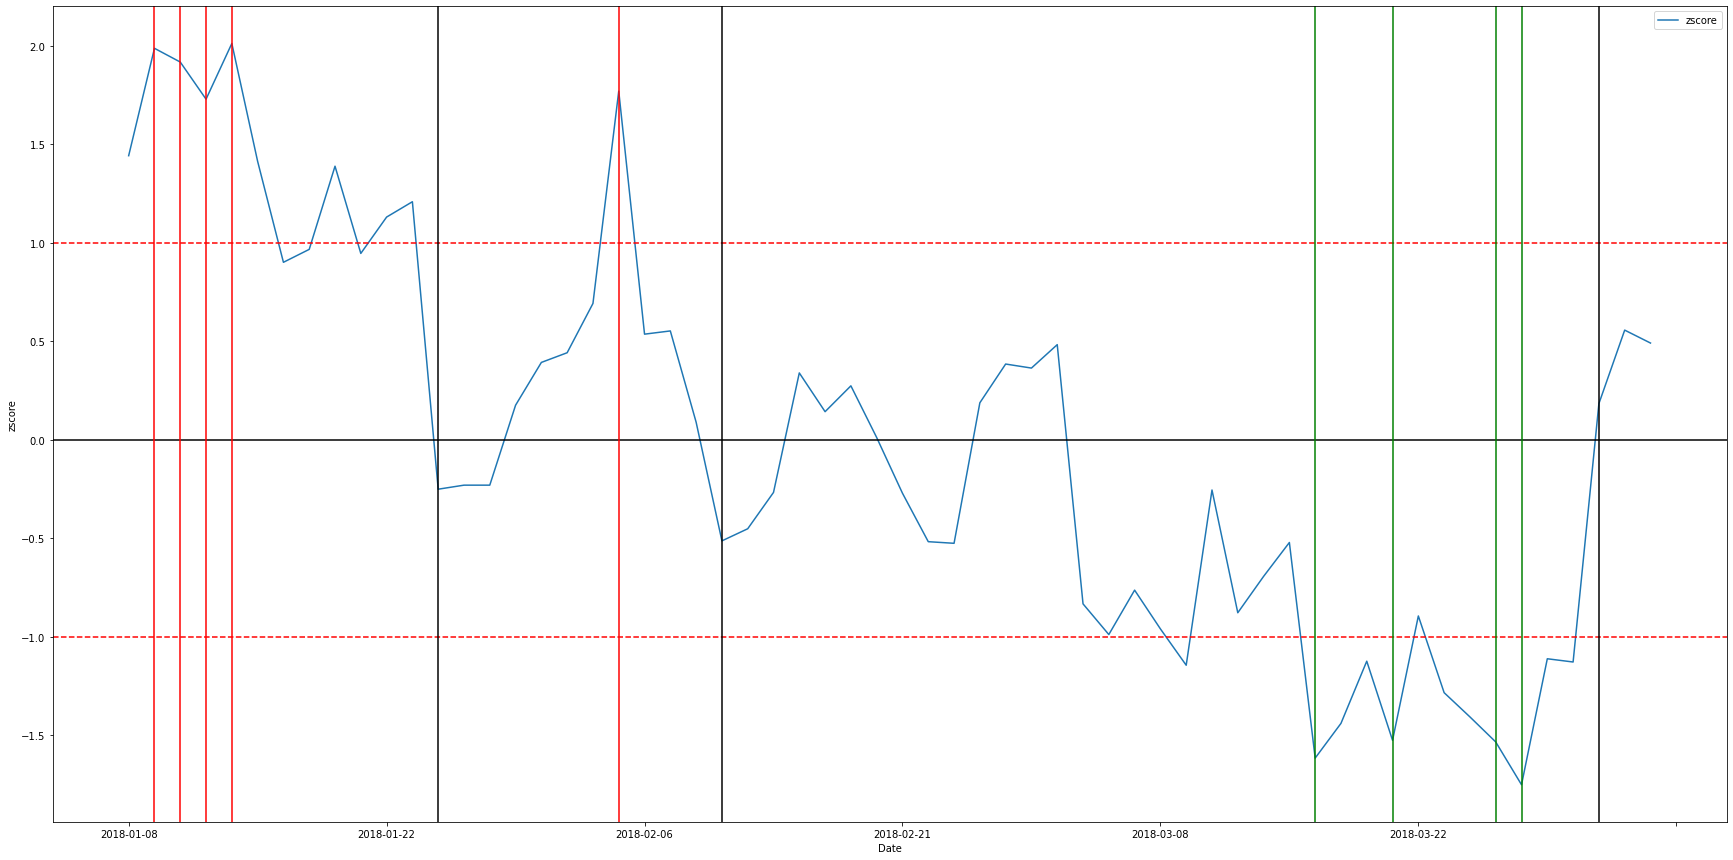

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

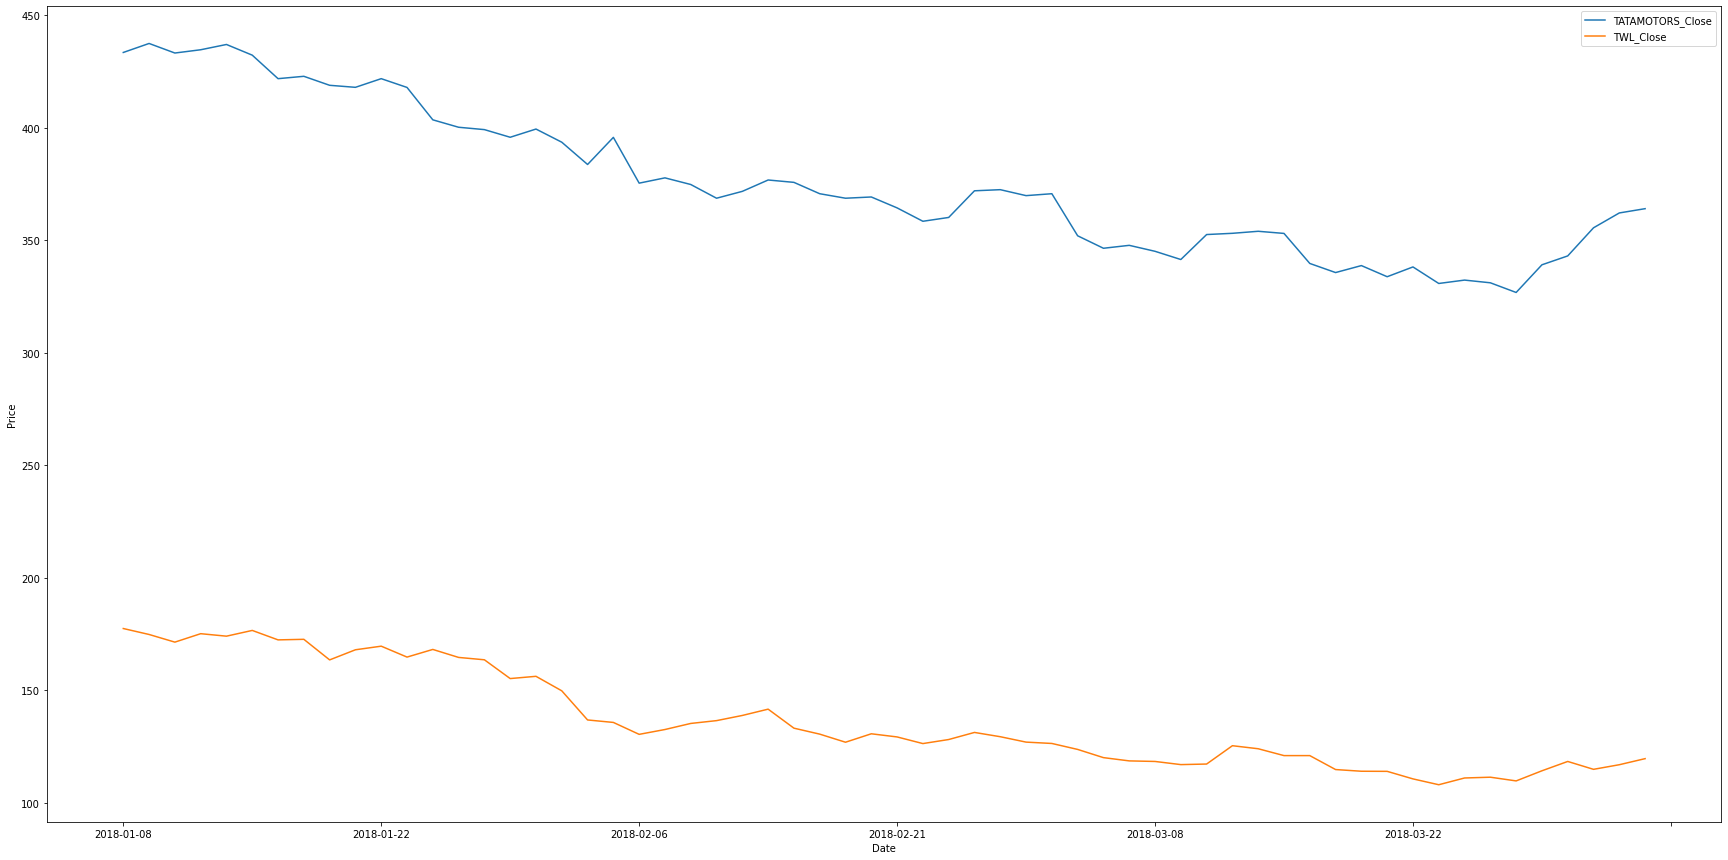

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['TATAMOTORS_Close', 'TWL_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. TWL Linear Regression Model

## 3.1. Get the Complete TWL dataset

In [6]:
TWL_df = pd.read_csv("../../Storage/Companies_with_names_exchange/TWLNSE.csv")
TWL_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,125.800003,122.699997,124.000000,125.150002,657433.0,122.965851,TWL,NSE
1,2017-01-03,132.899994,125.500000,126.150002,130.800003,2992973.0,128.517227,TWL,NSE
2,2017-01-04,132.300003,127.000000,131.600006,128.449997,1281617.0,126.208244,TWL,NSE
3,2017-01-05,129.649994,124.099998,129.000000,126.900002,1125281.0,124.685303,TWL,NSE
4,2017-01-06,129.350006,125.550003,127.400002,127.400002,841568.0,125.176567,TWL,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get TWL training data

### 3.2.1 Get complete TWL dataset

In [7]:
TWL_df = TWL_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
TWL_df.head()

,Date,Close
0,2017-01-02,125.150002
1,2017-01-03,130.800003
2,2017-01-04,128.449997
3,2017-01-05,126.900002
4,2017-01-06,127.400002


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
TWL_df_train = TWL_df[TWL_df['Date'] >= '2017-09-03']
TWL_df_train.head()

,Date,Close
166,2017-09-04,115.349998
167,2017-09-05,119.500000
168,2017-09-06,118.150002
169,2017-09-07,115.599998
170,2017-09-08,115.849998


In [9]:
TWL_df_train = TWL_df_train[TWL_df_train['Date'] <= '2018-09-04']
TWL_df_train.tail()

,Date,Close
412,2018-08-29,88.949997
413,2018-08-30,88.849998
414,2018-08-31,88.500000
415,2018-09-03,87.849998
416,2018-09-04,86.050003


### 3.2.3 Get the training data and labels

In [10]:
TWL_train = TWL_df_train.copy()
TWL_train

,Date,Close
166,2017-09-04,115.349998
167,2017-09-05,119.500000
168,2017-09-06,118.150002
169,2017-09-07,115.599998
170,2017-09-08,115.849998
...,...,...
412,2018-08-29,88.949997
413,2018-08-30,88.849998
414,2018-08-31,88.500000
415,2018-09-03,87.849998


In [11]:
TWL_train = TWL_train.reset_index(drop=True)
TWL_train = TWL_train['Close']
TWL_train

0      115.349998
1      119.500000
2      118.150002
3      115.599998
4      115.849998
          ...    
246     88.949997
247     88.849998
248     88.500000
249     87.849998
250     86.050003
Name: Close, Length: 251, dtype: float64

In [12]:
len(TWL_train)

251

## 3.3. Get TWL Test Data

In [13]:
TWL_test_df = orders_df.copy()
TWL_test_df = TWL_df[(TWL_df['Date'] >= '2018-09-04') & (TWL_df['Date'] <= '2018-12-03')].copy()
TWL_test_df.head()

,Date,Close
416,2018-09-04,86.050003
417,2018-09-05,84.900002
418,2018-09-06,85.949997
419,2018-09-07,87.349998
420,2018-09-10,86.199997


In [14]:
TWL_test_df.tail()

,Date,Close
470,2018-11-27,70.699997
471,2018-11-28,69.599998
472,2018-11-29,68.500000
473,2018-11-30,68.800003
474,2018-12-03,69.699997


In [15]:
TWL_test = TWL_test_df.copy()
TWL_test.reset_index(drop=True, inplace=True)
TWL_test.index += 251
TWL_test.head()

,Date,Close
251,2018-09-04,86.050003
252,2018-09-05,84.900002
253,2018-09-06,85.949997
254,2018-09-07,87.349998
255,2018-09-10,86.199997


In [16]:
TWL_test.tail()

,Date,Close
305,2018-11-27,70.699997
306,2018-11-28,69.599998
307,2018-11-29,68.500000
308,2018-11-30,68.800003
309,2018-12-03,69.699997


In [17]:
TWL_test = TWL_test['Close']

In [18]:
len(TWL_test)

59

## 3.4 Create and Train TWL Model

In [19]:
model = auto_arima(TWL_train, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(TWL_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1421.304, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1356.646, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.83 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1423.167, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1331.493, Time=1.03 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.77 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.51 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1329.960, Time=0.75 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1354.848, Time=0.30 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=7.84 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.55 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1331.501, Time=1.09 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1333.957, Time=1.60 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=1331.

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

## 3.5. Get predictions

In [20]:
forecast = model.predict(n_periods=len(TWL_test))
forecast = pd.DataFrame(forecast, index = TWL_test.index, columns=['Prediction'])
forecast

,Prediction
251,86.276492
252,85.608620
253,86.225199
254,85.538993
255,83.449136
256,81.107538
257,80.754823
258,85.303755
259,83.612673
260,83.149529


In [21]:
predictions = forecast['Prediction']
print('Mean Absolute Error:', metrics.mean_absolute_error(TWL_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(TWL_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(TWL_test, predictions)))

Mean Absolute Error: 9.564494653710412
Mean Squared Error: 115.39858993249037
Root Mean Squared Error: 10.742373570700767


## 3.6. Visualize the predicitons vs test data

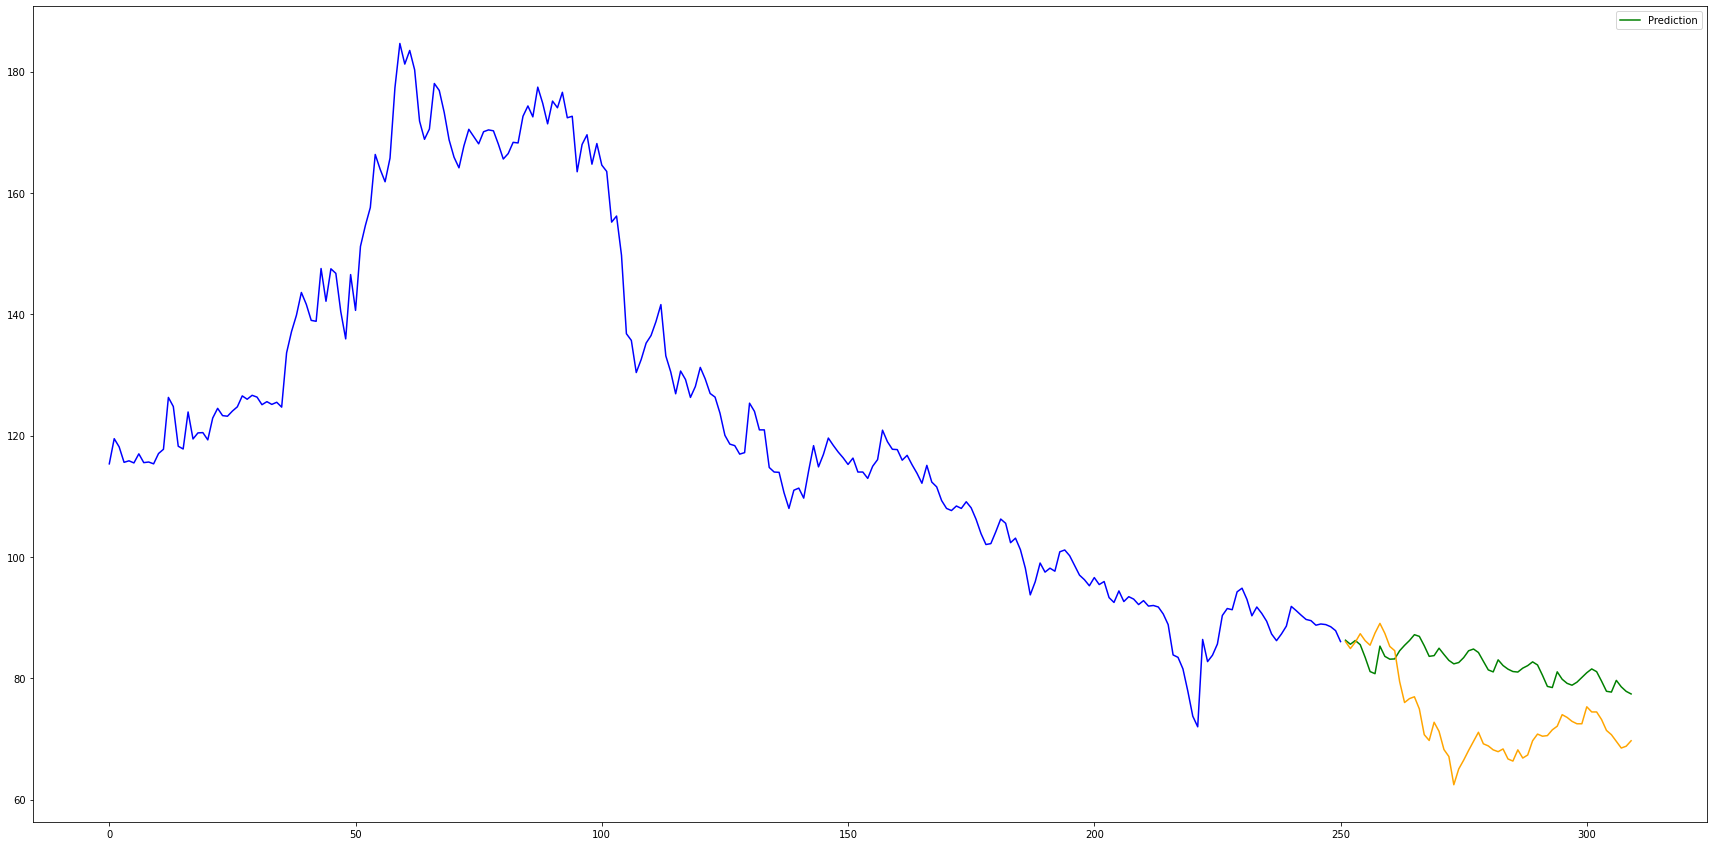

In [22]:
TWL_model_plt = forecast.plot(y=['Prediction'], figsize=(30,15), c='green')
TWL_model_plt.plot(TWL_train, c='blue')
TWL_model_plt.plot(TWL_test, c='orange')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [23]:
TWL_predictions_df = pd.read_csv('Twl_predicitions.csv')
TWL_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2018-01-08,177.449997,97.123234
1,2018-01-09,174.800003,97.166994
2,2018-01-10,171.399994,97.210755
3,2018-01-11,175.149994,97.254516
4,2018-01-12,174.050003,96.775293


In [24]:
forecast = forecast.reset_index()
forecast = forecast.drop(columns='index')
TWL_predictions_df['ARIMA_Close'] = forecast['Prediction']
TWL_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
0,2018-01-08,177.449997,97.123234,86.276492
1,2018-01-09,174.800003,97.166994,85.608620
2,2018-01-10,171.399994,97.210755,86.225199
3,2018-01-11,175.149994,97.254516,85.538993
4,2018-01-12,174.050003,96.775293,83.449136


In [25]:
TWL_predictions_df.to_csv('Twl_predicitions.csv', index=False)